In [11]:
import os
path = r'C:\Users\huda\Documents\GitHub\scheduling_model_jrc\code\upgrades\benchmarks'
sources = os.listdir(path)
#sources = [source for source in sources if os.path.isdir(source)] 

In [12]:
if 'DataSetExplanation.txt' in sources:
    sources.remove('DataSetExplanation.txt')
if 'all' in sources:
    sources.remove('all')

In [13]:
sources.sort()

In [14]:
import statistics
import math

def calculate_flexibility(machines_for_all_operations, n_machines):
    n_operations = len(machines_for_all_operations)
    machine_sum = 0

    for m in machines_for_all_operations:
        machine_sum += len(m)

    return (machine_sum/n_operations) / n_machines

def calculate_duration_variety(durations):
    counts = []
    unique_values = []
    for d in durations:
        count = 0
        for duration in d:
            if duration > 0:
                if duration not in unique_values:
                    unique_values.append(duration)
                count+=1
        counts.append(count)

    return len(unique_values) / sum(counts)

def calculate_average_operations(job_sequence):
    n_jobs = 1
    counts = [1]
    for i in range(1, len(job_sequence)):
        if job_sequence[i] != job_sequence[i-1]:
            n_jobs+=1
            counts.append(0)
        counts[-1] += 1
    return (sum(counts))/n_jobs

def calculate_duration_features_workers(durations):
    all_durations = []
    for duration in durations:
        for d in duration:
            all_durations.extend(d)
    all_durations = [d for d in all_durations if d != 0]
    min_duration = min(all_durations)
    max_duration = max(all_durations)
    span = max_duration - min_duration
    stdev = statistics.stdev(all_durations)
    return min_duration, max_duration, span, stdev

def calculate_duration_features(durations):
    all_durations = []
    for duration in durations:
        all_durations.extend(duration)
    all_durations = [d for d in all_durations if d != 0]
    min_duration = min(all_durations)
    max_duration = max(all_durations)
    span = max_duration - min_duration
    #stdev = statistics.stdev(all_durations)
    mean = sum(all_durations)/len(all_durations)
    var = sum(pow(x-mean, 2) for x in all_durations) / len(all_durations)
    stdev = math.sqrt(var)
    return min_duration, max_duration, span, stdev, mean


In [15]:
from benchmark_parser import BenchmarkParser
names = ['_'.join(source.split('_')[1:]) for source in sources]
feature_vectors = []
consider_duration_features = True
with open('benchmarks.csv', 'a') as out_file:
    out_file.write('Source;Instance;n_jobs;n_machines;n_operations;flexibility;duration_variety;average_operations_per_job;min_duration;max_duration;duration_span;duration_stdev;mean\n')
for i in range(len(sources)):
    name = names[i]
    source = sources[i]
    print(f'{name} - {source}')
    instances = os.listdir(path + '/' + source)
    instances.sort()
    for instance in instances:
        parser = BenchmarkParser()
        encoding = parser.parse_benchmark(path + '/' + source + '/' + instance)
        min_d, max_d, d_span, d_stdev, mean = calculate_duration_features(encoding.durations())
        extracted_data = {
            "name": instance[:-4],
            "n_jobs": encoding.n_jobs(), 
            "n_machines": encoding.n_machines(),
            "n_operations": encoding.n_operations(),
            "flexibility": calculate_flexibility(encoding.get_machines_for_all_operations(), encoding.n_machines()),
            "duration_variety": calculate_duration_variety(encoding.durations()),
            "average_operations": calculate_average_operations(encoding.job_sequence()),
            "min_duration": min_d,
            "max_duration": max_d,
            "duration_span": d_span,
            "duration_std": d_stdev,
            "duration_mean": mean
        }
        with open('benchmarks.csv', 'a') as out_file:
            out_file.write(f'{source};{extracted_data["name"]};{extracted_data["n_jobs"]};{extracted_data["n_machines"]};{extracted_data["n_operations"]};{extracted_data["flexibility"]};{extracted_data["duration_variety"]};{extracted_data["average_operations"]};{extracted_data["min_duration"]};{extracted_data["max_duration"]};{extracted_data["duration_span"]};{extracted_data["duration_std"]};{mean}\n')
        feature_vector = [encoding.n_jobs(), encoding.n_machines(), encoding.n_operations(), extracted_data["flexibility"], extracted_data["duration_variety"], extracted_data["average_operations"]]
        if consider_duration_features:
            feature_vector.extend([min_d, max_d, d_span, d_stdev])
        feature_vectors.append(feature_vector)

BehnkeGeiger - 0_BehnkeGeiger
Brandimarte - 1_Brandimarte
Hurink_sdata - 2a_Hurink_sdata
Hurink_edata - 2b_Hurink_edata
Hurink_rdata - 2c_Hurink_rdata
Hurink_vdata - 2d_Hurink_vdata
DPpaulli - 3_DPpaulli
ChambersBarnes - 4_ChambersBarnes
Kacem - 5_Kacem
Fattahi - 6_Fattahi


In [16]:
from sklearn.cluster import KMeans
inertias = []
n_clusters = 20
centers = []
results = []
for i in range(1, n_clusters+1):
    kmeans = KMeans(n_clusters=i)
    results.append(kmeans.fit_predict(feature_vectors))
    centers.append(kmeans.cluster_centers_)
    
    inertias.append(kmeans.inertia_)

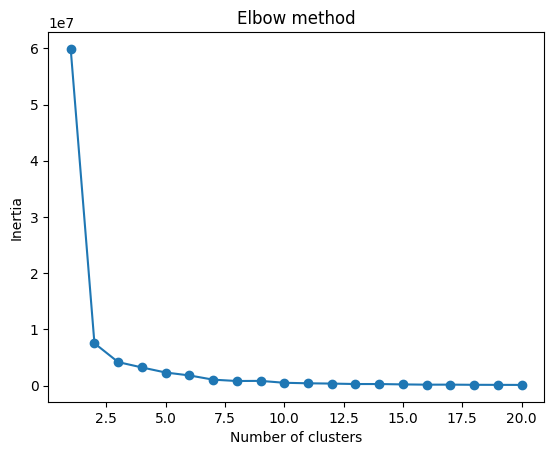

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(1,n_clusters+1), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

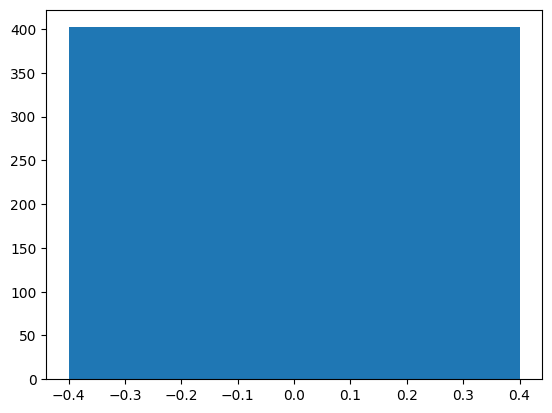

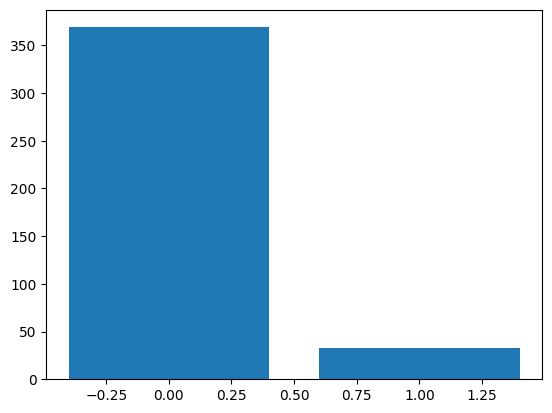

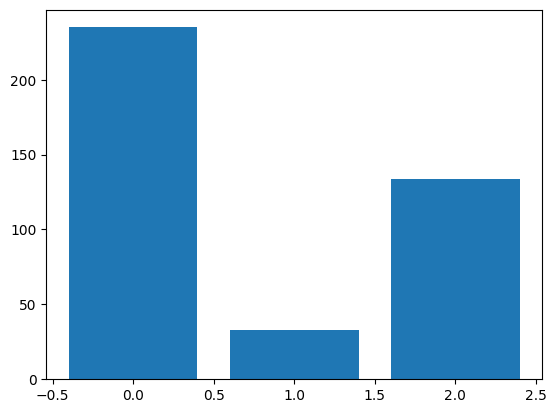

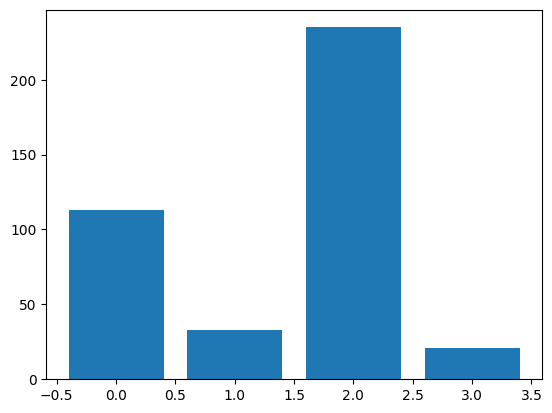

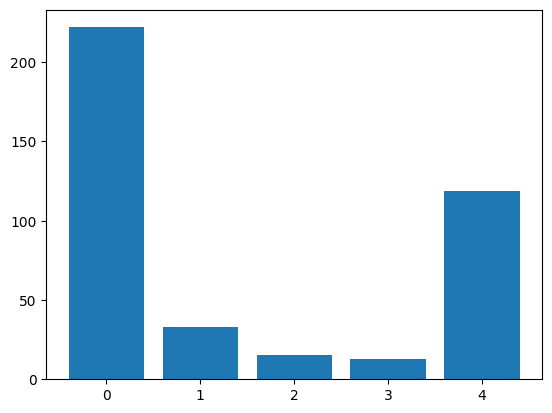

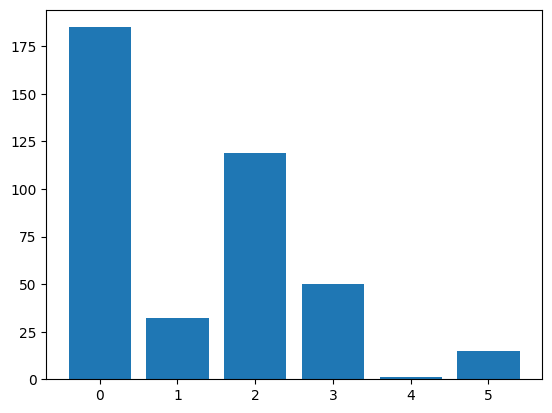

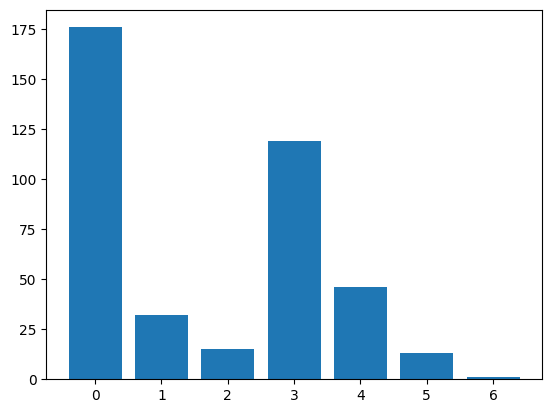

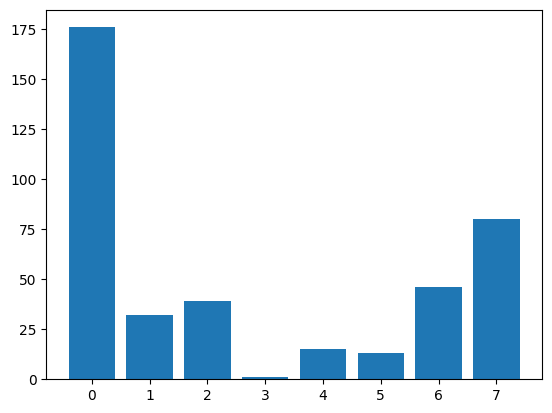

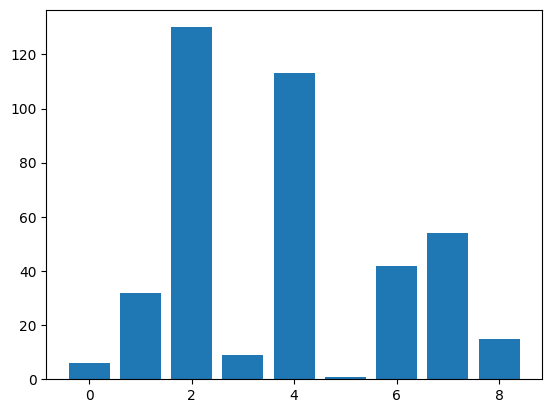

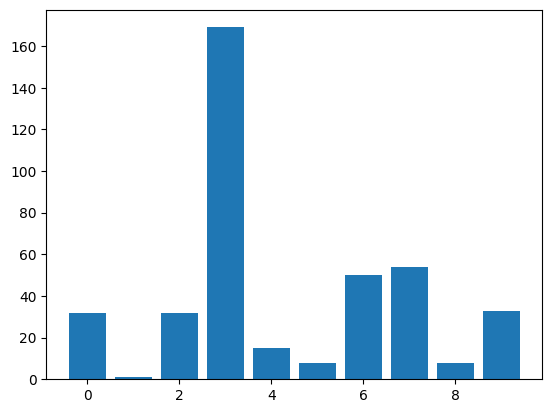

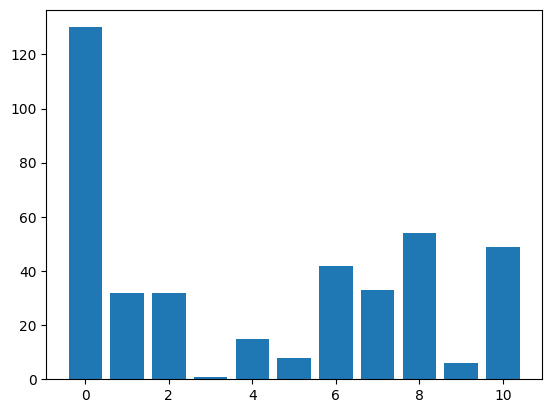

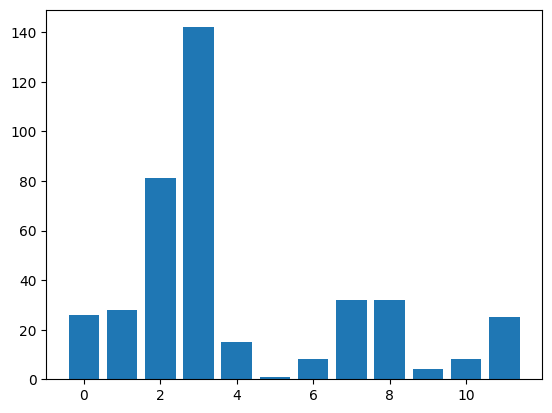

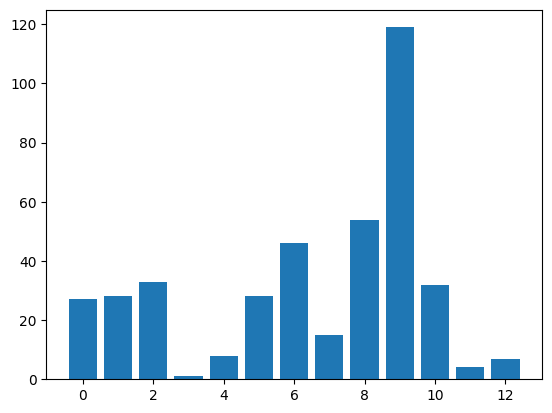

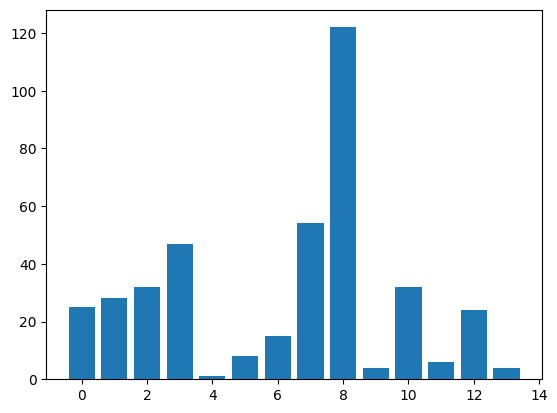

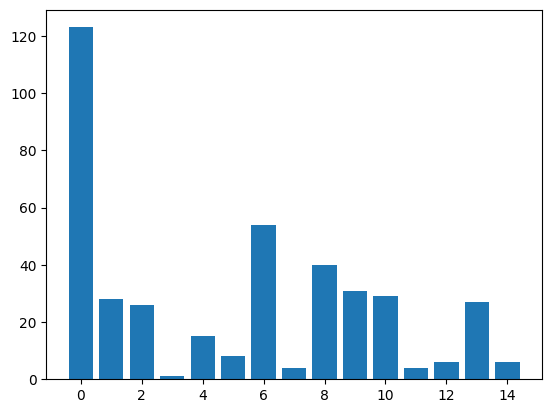

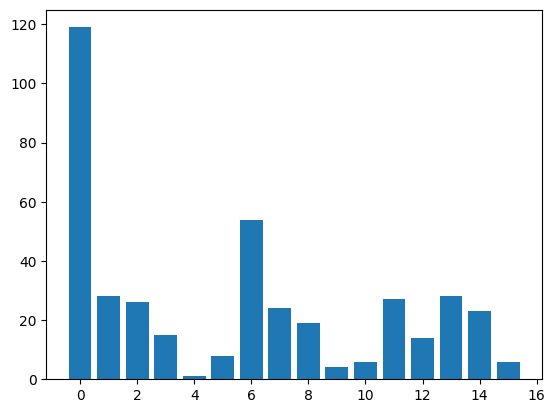

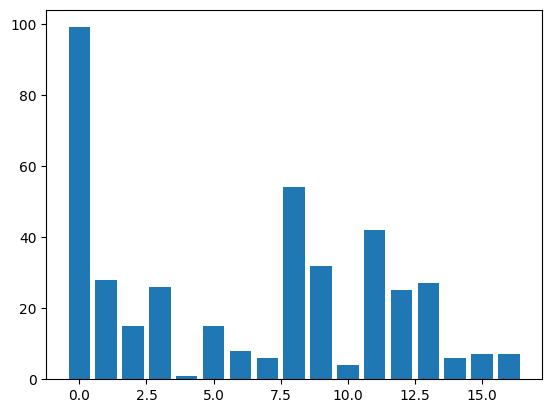

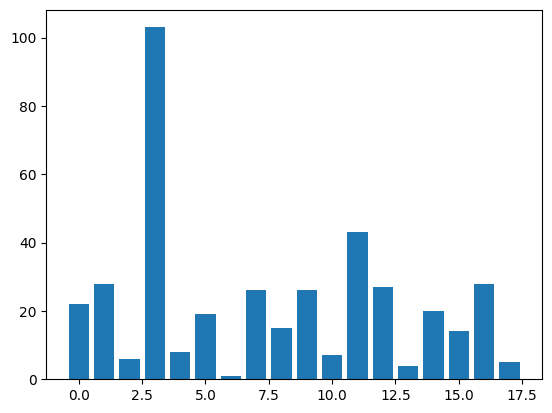

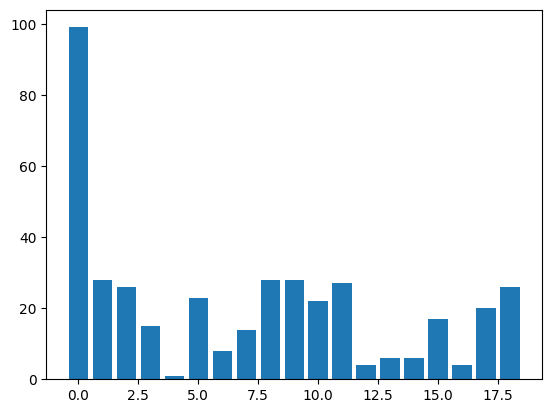

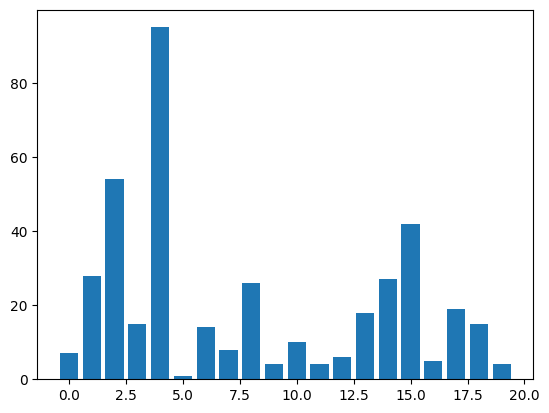

In [18]:
def counts(result):
    bars = [0] * (max(result)+1)
    for value in result:
        bars[value] += 1
    return bars

for i in range(len(results)):
    result = results[i]
    plt.bar(range(0,max(result)+1), counts(result))
    plt.show()
